In [16]:
from rank_bm25 import BM25Okapi
import nltk
import re
import pickle
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [21]:
# read data from csv
data = pd.read_csv("protocols/labelled/only_lockdown.csv", sep='\t', header=None, skiprows=[0])

# Create binary grade, class 1-2 or 5-6  = good or bad
data["opinion_integer"] = 0
data.loc[data[6] == '-', "opinion_integer"] = 0
data.loc[data[6] == 'o', "opinion_integer"] = 1
data.loc[data[6] == '+', "opinion_integer"] = 2

In [22]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    tokenizer = nltk.RegexpTokenizer(r"\w+")
    word_tokens = tokenizer.tokenize(text)
    words_tokens_lower = [word for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]
    return words_filtered

[nltk_data] Downloading package stopwords to /home/stefan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/stefan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
%%time
# Clean Comments
data["comment_clean"] = data.loc[data[13].str.len() > 20, 13]
data["comment_clean"] = data["comment_clean"].map(
    lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x
)

CPU times: user 46.3 ms, sys: 0 ns, total: 46.3 ms
Wall time: 45.5 ms


In [24]:
# Drop Missing
data = data.dropna(axis="index", subset=["opinion_integer", "comment_clean"]).reset_index(
    drop=True
)
data = data[["comment_clean", "opinion_integer"]]
data.columns = ["text", "label"]

,text,label
0,"[Das, heißt, diese, Planbarkeit, ist, jetzt, g...",0
1,"[Wie, und, wann, schaffen, wir, es, aus, diese...",0


In [67]:
def split_df(df, split_number):
    return df[:split_number], df[split_number:]

def corpus_split(holdback_per_class):
    train = pd.DataFrame()
    test = pd.DataFrame()

    for i in range(3):
        rows_with_class = data[data['label'] == i]
        rows_with_class = rows_with_class.sample(frac=1).reset_index(drop=True)
        l, r = split_df(rows_with_class, holdback_per_class)
        train = train.append(r, ignore_index=True)
        test = test.append(l, ignore_index=True)

    train = train.sample(frac=1).reset_index(drop=True)
    test = test.sample(frac=1).reset_index(drop=True)

    train_x = train['text'].tolist()
    test_x = test['text'].tolist()
    train_y = train['label'].tolist()
    test_y = test['label'].tolist()

    return train_x, test_x, train_y, test_y

In [59]:
def predict(bm25, x_test, y_lookup, n_best, use_class_weights = False):
    class_counts = np.bincount(y_lookup)
    max_class_count = max(class_counts)
    class_weights = max_class_count / class_counts

    y_preds = []
    for x_query in x_test:
        scores = bm25.get_scores(x_query)
        argmaxima = scores.argsort()[-n_best:][::-1]
        # pred_scores = scores[argmaxima]
        # preds = y_lookup[argmaxima]
        weighted_scores = [0, 0, 0]
        for am in argmaxima:
            pred = y_lookup[am]
            if use_class_weights:
                weighted_scores[pred] += scores[am] * class_weights[pred]
            else:
                weighted_scores[pred] += scores[am]
        # pred_label = np.argmax(np.bincount(preds))
        pred_label = np.argmax(weighted_scores)
        y_preds.append(pred_label)
    return np.array(y_preds)

In [64]:
def perform_runs(runs, n_best, use_class_weights):
    accuracies = []

    for i in range(runs):
        # Split corpus
        #lookup_docs, test_docs, lookup_labels, test_labels = train_test_split(data['text'].tolist(), data["label"].tolist(), test_size=0.15, shuffle=True, stratify=data["label"])
        lookup_docs, test_docs, lookup_labels, test_labels = corpus_split(20)
        lookup_labels = np.array(lookup_labels)
        bm25 = BM25Okapi(lookup_docs)

        # Predict
        predictions = predict(bm25, test_docs, lookup_labels, n_best, use_class_weights)

        # Evaluate
        correct = predictions == np.array(test_labels)
        accuracy = correct.sum() / correct.size
        accuracies.append(accuracy)
    return np.array(accuracies)

In [72]:
n_best_counts = np.arange(1,21)
mean_accs = []
for n_best_count in n_best_counts:
    print(f"Calculating {n_best_count} n_best")
    accs = perform_runs(100, n_best_count, False)
    mean_accs.append(accs.mean())

Calculating 1 n_best
Calculating 2 n_best
Calculating 3 n_best
Calculating 4 n_best
Calculating 5 n_best
Calculating 6 n_best
Calculating 7 n_best
Calculating 8 n_best
Calculating 9 n_best
Calculating 10 n_best
Calculating 11 n_best
Calculating 12 n_best
Calculating 13 n_best
Calculating 14 n_best
Calculating 15 n_best
Calculating 16 n_best
Calculating 17 n_best
Calculating 18 n_best
Calculating 19 n_best
Calculating 20 n_best


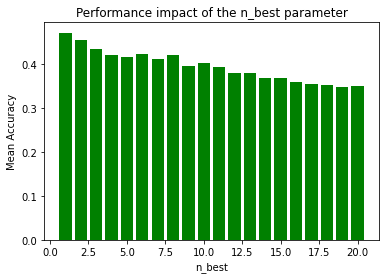

In [73]:
import matplotlib.pyplot as plt
plt.bar(n_best_counts, mean_accs, color='green')
plt.xlabel("n_best")
plt.ylabel("Mean Accuracy")
plt.title("Performance impact of the n_best parameter")
plt.savefig('plots/bm25okapi_n_best_no_class_weights_even_class.png')
plt.show()

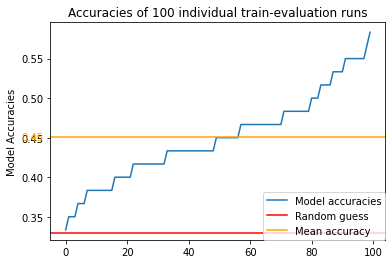

In [69]:
accuracies = perform_runs(500, 10, False)

import matplotlib.pyplot as plt
import numpy as np

total = len(accuracies)
mean = sum(accuracies)/total

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sorted(accuracies), label='Model accuracies')
plt.axhline(y=0.33, color='r', linestyle='-', label='Random guess')
plt.axhline(y=mean, color='orange', linestyle='-', label='Mean accuracy')
ax.text(-0.02, mean, "{:.2f}".format(mean), color='orange', ha="right", va="center",
        transform=ax.get_yaxis_transform())
plt.ylabel('Model Accuracies')
plt.title(f"Accuracies of {total} individual train-evaluation runs")
plt.legend(loc="lower right", borderaxespad=0)
plt.savefig('plots/accuracies_bm25okapi_no_class_weights_even_class.png')
plt.show()

In [55]:
# Random guess accuracy
import numpy.random
lookup_docs, test_docs, lookup_labels, test_labels = corpus_split(20)
preds = numpy.random.choice(lookup_labels, len(test_labels))
correct = preds == test_labels
print(f"Accuracy class weight predictions: {correct.sum() / correct.size}")
preds = numpy.random.choice([0], len(test_labels))
correct = preds == test_labels
print(f"Accuracy 0,1: {correct.sum() / correct.size}")

Accuracy class weight predictions: 0.23333333333333334
Accuracy 0,1: 0.3333333333333333


<ipython-input-52-55f5eae5686e>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_x = np.array(train['text'].tolist())
<ipython-input-52-55f5eae5686e>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  test_x = np.array(test['text'].tolist())


In [56]:
np.bincount(lookup_labels)

array([256, 106,  70])